### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from imblearn.over_sampling import SMOTE
from zipfile import ZipFile

import wrangle

### Certain configs for visualizations

In [2]:
import matplotlib.style as style
style.use('seaborn-colorblind')

/var/folders/h6/xxqcvddd61v8kq3bhvkfyqzw0000gn/T/ipykernel_34137/29349232.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


### Acquire datasets

In [3]:
test, df = wrangle.acquire_fraud('cc_fraud.zip')

In [4]:
test.shape,df.shape

((555719, 23), (1296675, 23))

### Clean and Prep

In [5]:
df = wrangle.prep(df)
test = wrangle.prep(test)

In [6]:
df.head()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,,
2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,28654,3495,"Psychologist, counselling",36.011293,-82.048315,0,30,Tuesday,0,Young_Adult
2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,99160,149,Special educational needs teacher,49.159047,-118.186462,0,40,Tuesday,0,Adult
2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,83252,4154,Nature conservation officer,43.150704,-112.154481,0,56,Tuesday,0,Mid_Age
2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,59632,1939,Patent attorney,47.034331,-112.561071,0,52,Tuesday,0,Early_Mid_Age
2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,24433,99,Dance movement psychotherapist,38.674999,-78.632459,0,32,Tuesday,0,Young_Adult


### Define target ('is_fraud') versus the rest of the features

In [7]:
target,features = wrangle.get_target_and_features(df)
print(target)
print('______')
print(features)

is_fraud
______
['merchant', 'category', 'amt', 'gender', 'zip', 'city_pop', 'job', 'merch_lat', 'merch_long', 'age', 'dayofweek', 'hourofday', 'age_group']


### Split the training data further (into Train and Validate)

In [8]:
x_train,x_validate,y_train,y_validate = wrangle.train_val(df)

In [9]:
x_train.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,
2019-05-02 04:19:03,fraud_Hackett-Lueilwitz,grocery_pos,149.42,M,80824,207,Network engineer,38.854964,-101.76675,63,Thursday,4,Mid_Age


In [10]:
y_train.sample()

trans_date_trans_time
2019-01-06 00:58:26    0
Name: is_fraud, dtype: int64

### Break the TEST dataset into x and y sets

In [11]:
x_test,y_test = wrangle.test_df_x_y_split(test)

In [12]:
x_test.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,
2020-11-30 12:49:33,fraud_Rau-Robel,kids_pets,37.17,F,58651,475,Illustrator,47.119665,-103.594652,65,Monday,12,Retirement_Age


In [13]:
y_test.sample()

trans_date_trans_time
2020-06-23 05:13:27    0
Name: is_fraud, dtype: int64

# Begin EDA (using the original DF, which includes train and validate data)

In [14]:
# df.isna().sum()
# There are NO nulls

### First of all...CLASS IMBALANCE?

In [15]:
df.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

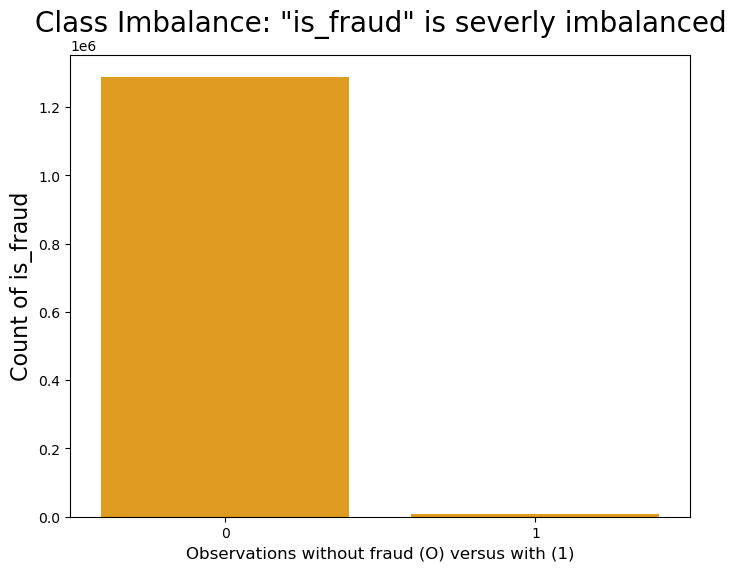

In [16]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(x=df['is_fraud'],color='orange')
ax.set_xlabel(xlabel = 'Observations without fraud (O) versus with (1)', fontsize = 12)
ax.set_ylabel(ylabel = 'Count of is_fraud', fontsize = 16)
ax.set_title(label = 'Class Imbalance: "is_fraud" is severly imbalanced', fontsize = 20)

plt.show()

### Amount?

In [17]:
amount_df = df.copy()
amount_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,,
2020-02-07 17:03:10,"fraud_Hermiston, Pacocha and Smith",health_fitness,36.91,F,59448,743,Water engineer,48.718648,-113.625118,0,47,Friday,17,Early_Mid_Age


In [18]:
amount_df.amt.min(),amount_df.amt.max()

(1.0, 28948.9)

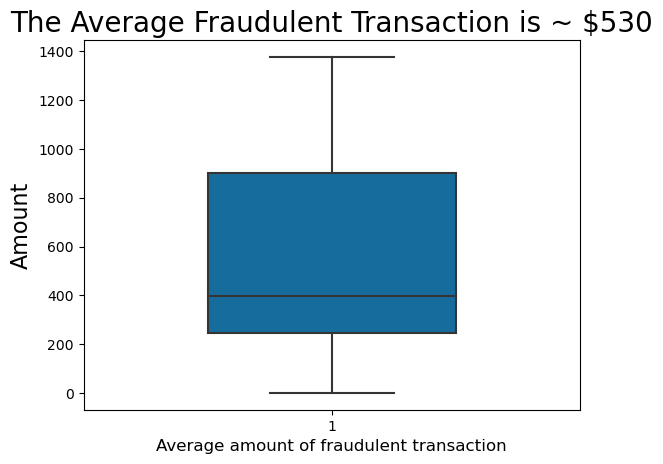

In [19]:
ax = sns.boxplot(data=amount_df[amount_df['is_fraud']==1],y=amount_df[amount_df['is_fraud']==1].amt,x=amount_df[amount_df['is_fraud']==1].is_fraud,width=.5)
ax.set_xlabel(xlabel = 'Average amount of fraudulent transaction', fontsize = 12)
ax.set_ylabel(ylabel = 'Amount', fontsize = 16)
ax.set_title(label = 'The Average Fraudulent Transaction is ~ $530', fontsize = 20)
plt.show()

In [20]:
df[df['is_fraud']==1].amt.min(),df[df['is_fraud']==1].amt.max(),df[df['is_fraud']==1].amt.mean()

(1.06, 1376.04, 531.3200919264589)

In [21]:
np.arange(0,1200,50)

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150])

In [45]:
bins = [   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150,35000]

In [46]:
labels = ['0_50','50_100','100_150','150_200','200_250','250_300','300_350','350_400','400_450','450_500','500_550','550_600','600_650','650_700','700_750','750_800','800_850','850_900','900_950','950_1000','1000_1050','1050_1100','1100_1150','over_1150']

In [47]:
# df['age_group'] = pd.cut(df['age'],[0,25,35,45,55,65,75,100], labels= ['Youth','Young_Adult','Adult','Early_Mid_Age','Mid_Age','Retirement_Age','Older_Person'],right=False)

amount_df['amt_bin'] = pd.cut(amount_df['amt'],bins=bins,labels=labels, right = False)
amount_df.sample(2)

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin
trans_date_trans_time,,,,,,,,,,,,,,,
2019-06-12 16:03:54,fraud_Ernser-Lynch,food_dining,65.59,M,20017,601723,"Psychotherapist, child",39.457869,-76.030645,0,28,Wednesday,16,Young_Adult,50_100
2019-07-03 17:47:55,"fraud_Hermiston, Pacocha and Smith",health_fitness,68.54,F,20687,313,Insurance underwriter,37.896170,-76.924136,0,43,Wednesday,17,Adult,50_100


In [48]:
amount_df[amount_df['is_fraud']==1].amt_bin.value_counts()

amt_bin
0_50         1607
300_350       974
250_300       701
900_950       487
950_1000      456
850_900       450
750_800       411
800_850       381
1000_1050     364
1050_1100     282
700_750       252
350_400       186
1100_1150     165
100_150       145
over_1150     139
650_700       122
200_250        94
450_500        61
500_550        50
50_100         45
600_650        45
550_600        44
400_450        40
150_200         5
Name: count, dtype: int64

### Could there be a polynomial relationship in the amount bins?

In [49]:
# amount_df['amt_bin_fraud_ratio'] = 
# amount_df[amount_df['is_fraud']==1]['amt_bin']

down_sample = amount_df.sample(10_000)

In [50]:
down_sample.head(1)

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin
trans_date_trans_time,,,,,,,,,,,,,,,
2019-11-24 06:16:26,"fraud_Schaefer, McGlynn and Bosco",gas_transport,74.48,F,97014,1288,Barrister,44.77729,-122.011354,0,83,Sunday,6,Older_Person,50_100


In [51]:
# down_sample.amt.groupby([down_sample['amt_bin'],down_sample['is_fraud'],down_sample['amt_bin']]).size().unstack(0)
down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0)

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,5159,3063,961,303,192,57,39,37,19,25,...,3,5,5,5,2,3,2,4,1,12
1,13,1,1,0,0,8,10,0,0,0,...,3,4,4,3,3,1,2,0,1,1


In [52]:
bins_fraud_breakdown = down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0)
bins_fraud_sum = down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0).sum()

In [53]:
percentage_df = bins_fraud_breakdown/bins_fraud_sum
percentage_df

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,0.997486,0.999674,0.99896,1.0,1.0,0.876923,0.795918,1.0,1.0,1.0,...,0.5,0.555556,0.555556,0.625,0.4,0.75,0.5,1.0,0.5,0.923077
1,0.002514,0.000326,0.00104,0.0,0.0,0.123077,0.204082,0.0,0.0,0.0,...,0.5,0.444444,0.444444,0.375,0.6,0.25,0.5,0.0,0.5,0.076923


In [54]:
ratio_fraud = percentage_df[percentage_df.index == 1]
ratio_fraud

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
1,0.002514,0.000326,0.00104,0.0,0.0,0.123077,0.204082,0.0,0.0,0.0,...,0.5,0.444444,0.444444,0.375,0.6,0.25,0.5,0.0,0.5,0.076923


In [55]:
temp_df = pd.DataFrame(ratio_fraud.unstack(0)).droplevel(1)
temp_df

,0
amt_bin,
0_50,0.002514
50_100,0.000326
100_150,0.001040
150_200,0.000000
200_250,0.000000
250_300,0.123077
300_350,0.204082
350_400,0.000000
400_450,0.000000


In [56]:
fraud_ratio_per_bin_df = amount_df.merge(temp_df,on=['amt_bin'])

In [57]:
fraud_ratio_per_bin_df = fraud_ratio_per_bin_df.rename(columns={0:'perc_fraud_in_bin'})

In [58]:
fraud_ratio_per_bin_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin,perc_fraud_in_bin
521438,fraud_Stark-Koss,home,29.15,F,98304,759,Video editor,46.525338,-121.033274,0,63,Sunday,17,Mid_Age,0_50,0.002514


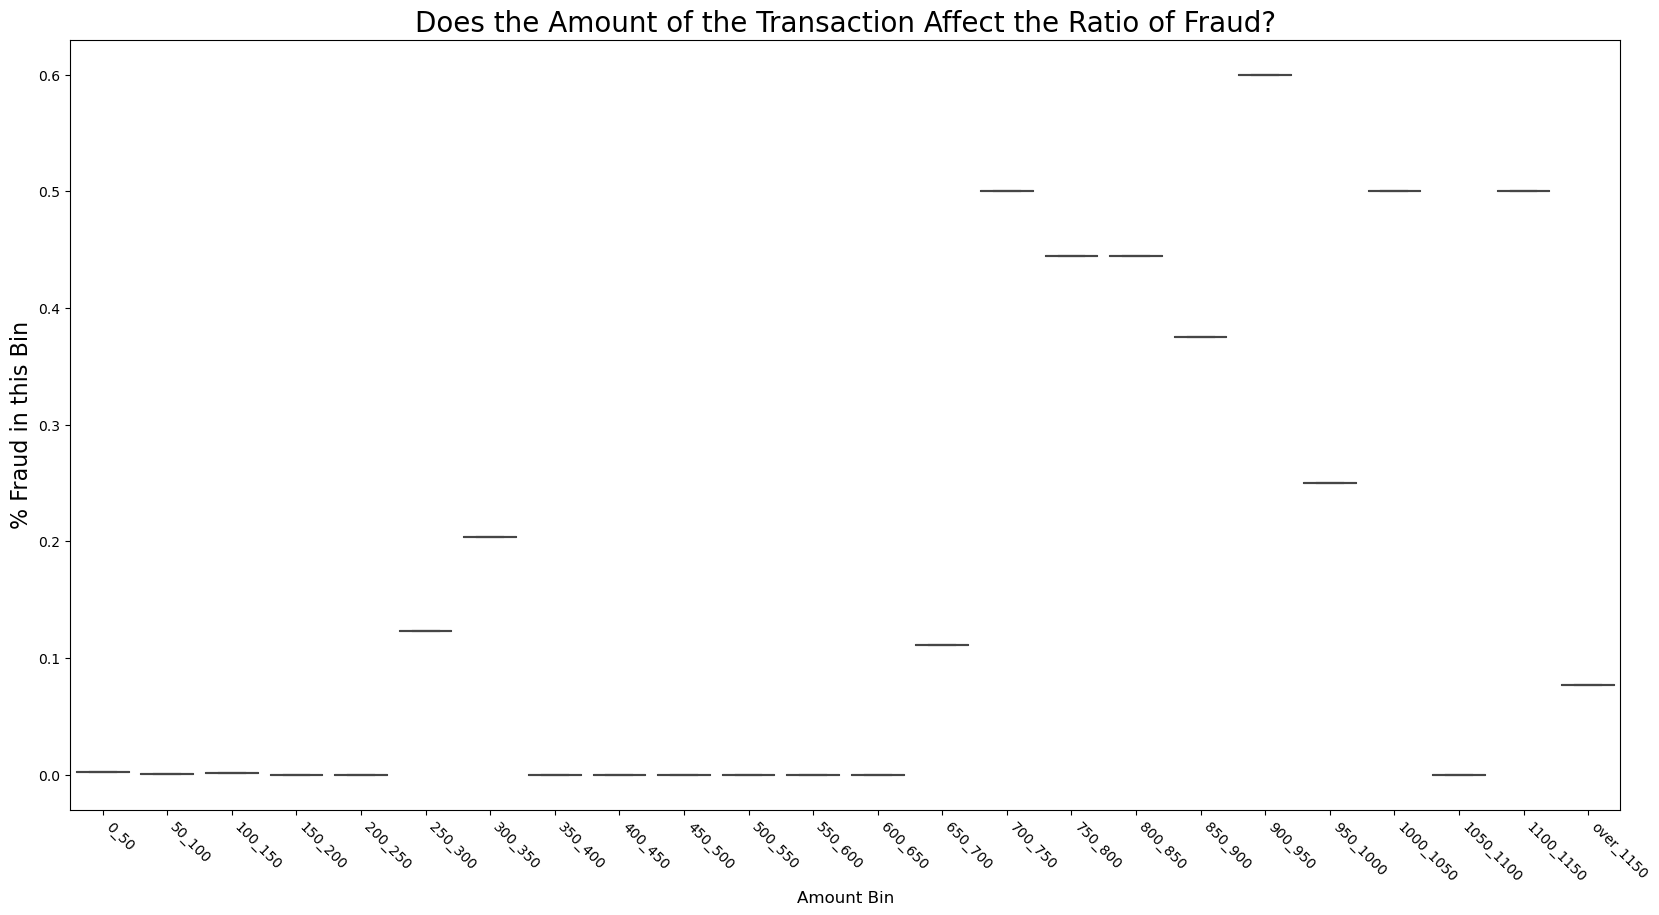

In [82]:
plt.figure(figsize = (20, 10))
ax = sns.boxplot(data=fraud_ratio_per_bin_df,y=fraud_ratio_per_bin_df.perc_fraud_in_bin,x=fraud_ratio_per_bin_df.amt_bin)
ax.set_xlabel(xlabel = 'Amount Bin', fontsize = 12)
ax.set_ylabel(ylabel = '% Fraud in this Bin', fontsize = 16)
ax.set_title(label = 'Does the Amount of the Transaction Affect the Ratio of Fraud?', fontsize = 20)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
plt.show()

In [60]:
temp_df2 = fraud_ratio_per_bin_df[fraud_ratio_per_bin_df['amt_bin']=='0_50']
temp_df2.head()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin,perc_fraud_in_bin
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,28654,3495,"Psychologist, counselling",36.011293,-82.048315,0,30,Tuesday,0,Young_Adult,0_50,0.002514
1,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,59632,1939,Patent attorney,47.034331,-112.561071,0,52,Tuesday,0,Early_Mid_Age,0_50,0.002514
2,fraud_Keeling-Crist,misc_pos,41.96,M,24433,99,Dance movement psychotherapist,38.674999,-78.632459,0,32,Tuesday,0,Young_Adult,0_50,0.002514
3,fraud_Rowe-Vandervort,grocery_net,44.54,F,67851,2691,Arboriculturist,37.162705,-100.153370,0,25,Tuesday,0,Young_Adult,0_50,0.002514
4,fraud_Herzog Ltd,misc_pos,4.27,F,15665,1472,Public affairs consultant,40.351813,-79.958146,0,77,Tuesday,0,Older_Person,0_50,0.002514


In [64]:
temp_df.head(1)

,0
amt_bin,
0_50,0.002514


In [70]:
percentage_df

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,0.997486,0.999674,0.99896,1.0,1.0,0.876923,0.795918,1.0,1.0,1.0,...,0.5,0.555556,0.555556,0.625,0.4,0.75,0.5,1.0,0.5,0.923077
1,0.002514,0.000326,0.00104,0.0,0.0,0.123077,0.204082,0.0,0.0,0.0,...,0.5,0.444444,0.444444,0.375,0.6,0.25,0.5,0.0,0.5,0.076923


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

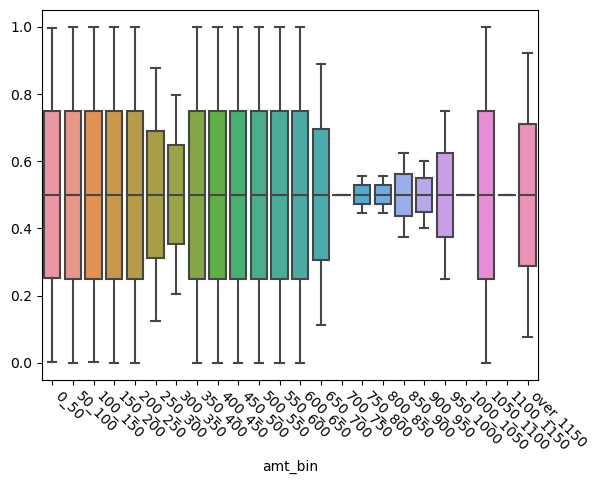

In [78]:
# plt.figure(figsize = (20, 20))
ax = sns.boxplot(data=percentage_df)
# ax.set_xlabel(xlabel = 'Amount Bin', fontsize = 12)
# ax.set_ylabel(ylabel = '% Fraud in this Bin', fontsize = 16)
# ax.set_title(label = 'Does the Amount of the Transaction Affect tdhe Ratio of Fraud?', fontsize = 20)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
# plt.show()

In [ ]:
ax = sns.boxplot(data=amount_df,y=amount_df.amt,x=amount_df.amt_bin,hue=amount_df.is_fraud,width=.5)
ax.set_xlabel(xlabel = 'Average amount of the fraudulent transaction', fontsize = 12)
ax.set_ylabel(ylabel = 'Amount by Bin', fontsize = 16)
ax.set_title(label = 'Certain Transaction Amounts Are More Prone to Fraud', fontsize = 20)
plt.xticks(rotation=30)
plt.show()


In [ ]:
df.columns